In [1]:
print("hello")

hello


In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits import mplot3d
from numpy.random import uniform


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault

import keras
from keras import initializers
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout 
from keras.layers import LeakyReLU, Flatten, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.image import grayscale_to_rgb
from tensorflow import expand_dims


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import time

from keras import backend as K


# Problem 1.1
Source: https://ruder.io/optimizing-gradient-descent/



#optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam']
Constant learning rate for all features can cause problems because some features might be changing more than other features.
We adpat the learning rate for features so that the decay correspond to the update frequency.<br />

Let learning rate = $\eta$ <br />
Gadient at t = $g_t$ <br />
$\theta_{t+1} = \theta_{t} - \eta* g_t$ <br />

When we have d features with d weights.
For each weight i of d, we calculate the gradient at t for each i, giving us $g_{t,i}$, so weight update looks like:


$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot g_{t,i}$ <br />



## Adagrad
Adagrad keeps running sum of the squared gradients for each dimension/feature.

Adagrad takes the square root of this squared gradient. It adds a small epsilon term so that the denominator is not zero, typically 
epsilon=1e-07 <br />

Let:<br />
$G_{t,ii}$ = Sum of Squared Gadient at t for weight i  <br />
$G_{t,ii}$ is a diagonal matrix with dimension $d xd$, where i,i element is the sum of squares of the gradient with respect to $\theta_i$ at time t. 

$g_{t,i} $ = calculate_gradient() <br />
$G_{t,ii} = G_{t-1,ii} + g_{t,i} * g_{t,i}$ <br />
$\theta_{t+1,i} = \theta_{t,i}  - \frac{\eta}{\sqrt {G_{t,ii} + \epsilon}}\cdot g_{t,i}$ <br />

The adgrad learning rate decays by factor of sum of past gradients.
When we have a gradient that's changing by a lot, the $G_t$ term is a large number. Dividing by large number means we slow down in that dimension.

But over the course of training, as t gets larger and larger, since it's accumulating all the past squared gradient sums, the steps get smaller and smaller over time. 

## RMSprop
RMSprop modifies Adagrad to address the problem of accumulated squared gradient that may slow down too much. <br />
It decays the squared gradient term using decay rate of rho: $\rho$, which is usually 0.9.

$g_t$ = calculate_gradient() <br />
grad_squared = $\rho$*grad_squared +  (1- $\rho$) $g_t$ * $g_t$ <br />
$w_{t+1}- w_{t} = - \frac{\eta}{\sqrt {grad_squared + \epsilon}}* g_t$ <br />

## RMSprop+Nesterov
RMSprop+Nesterov
RMSprop with nesterov momentum

## Adam
Adam updates the RMSProp, it's RMSprop with momentum.
Adam keeps exponentially decaying average of both the past squared gradients $v_t$ and gradients $m_t$ 

$m_t = \beta _{1} m_{t-1} + (1 - \beta _{1}) g_t$ <br />
$v_t = \beta _{2} v_{t-1} + (1 - \beta _{2}) g_t^2$<br /><br />

$m_t$ end up being estimate of the first moment, aka the mean of the gradient. <br />
And $v_t$ ennd up being estimate of the second moment, aka uncentered variance of the gradient. <br />

The $v_t$ and $m_t$ bias toward 0, so bias-corrected estimates are :

$\hat{m_t} = \frac{m_t}{1 - \beta _{1}^t}$

$\hat{v_t} = \frac{v_t}{1 - \beta _{2}^t}$

$\theta_{t+1} = \theta_{t}  - \frac{\eta}{\sqrt {\hat{v_t}} + \epsilon} \hat{m_t}$ <br />

## Adadelta
Adadelta also modifies Adagrad to address the problem of the learning rate decreasing so much that it's barely taking a step.
Instead of summing all past gradients, it only looks at a certain window of gradients and accumulates in that window w. But storing w previous gradients would be memory intensive, so this is handled by looking at the running average at time step t. The running average depends on previous time step's average. 

$E[g_t^2]_t = \gamma E[g_t^2]_{t_1} + ( 1- \gamma)* g_t^2$<br />
$\theta_{t+1,i} = \theta_{t,i}  - \frac{\eta}{\sqrt {E[g_t^2]_t + \epsilon}}\cdot g_{t,i}$ <br />

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [4]:
x_train = x_train /255.0
x_test = x_test /255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

We will use multi-layer neural network model with two fully connected hidden layers with 1000 hidden units each and ReLU activation with minibatch size of 128.

In [5]:
def build_l2model():
    
    model = Sequential()
    model.add(Flatten(input_shape = (32,32,3)))
    model.add(Dense(1000, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    model.add(Dense(1000,  activation='relu',
                kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    return model 

def build_dropoutmodel():
    model = Sequential()
    model.add(Flatten(input_shape = (32,32,3)))
    model.add(Dropout(0.2))
    model.add(Dense(1000,  activation='relu',
                    kernel_regularizer='l2',
                    kernel_initializer= 'HeNormal',
                      bias_initializer= 'zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(1000,  activation='relu',
                    kernel_regularizer='l2',
                    kernel_initializer= 'HeNormal',
                      bias_initializer= 'zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [7]:
#set up all the optimizers- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
#optimizers = ['Adagrad','RMSprop', 'NesRMSprop', 'Adadelta', 'Adam']
optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam', 'Nadam']

#Adagrad
tf.keras.optimizers.Adagrad(
learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,
name='Adagrad')

#RMSProp
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop')


#RMSProp+ Nesterov
tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Nadam'
)


#Adadelta
tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta'
)

#Adam
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

In [8]:
rows = []
test_result = []
epoch = 200

#build model
model = build_l2model()
print(model.summary())

#compile model 
for opt in optimizers:
    start = time.time()
    model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size = 128,  verbose= 2)
    end = time.time()
    train_time = end - start 
    #record training_loss
    for i in range(epoch):
        rows.append([opt, 'l2', i, history.history['loss'][i]])

    #determine test accuracy
    test_loss, test_acc = model.evaluate(x_test, y_test,  batch_size = 128, verbose = 0)
    test_result.append([opt, 'l2', test_loss, test_acc, train_time])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10010     
Total params: 4,084,010
Trainable params: 4,084,010
Non-trainable params: 0
_________________________________________________________________
None


2021-11-04 22:57:44.909926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
391/391 - 3s - loss: 41.2489 - accuracy: 0.2893
Epoch 2/200
391/391 - 2s - loss: 39.2313 - accuracy: 0.3532
Epoch 3/200
391/391 - 2s - loss: 37.4106 - accuracy: 0.3708
Epoch 4/200
391/391 - 2s - loss: 35.7033 - accuracy: 0.3848
Epoch 5/200
391/391 - 2s - loss: 34.0928 - accuracy: 0.3928
Epoch 6/200
391/391 - 2s - loss: 32.5711 - accuracy: 0.3987
Epoch 7/200
391/391 - 2s - loss: 31.1295 - accuracy: 0.4062
Epoch 8/200
391/391 - 2s - loss: 29.7645 - accuracy: 0.4095
Epoch 9/200
391/391 - 2s - loss: 28.4694 - accuracy: 0.4143
Epoch 10/200
391/391 - 2s - loss: 27.2405 - accuracy: 0.4195
Epoch 11/200
391/391 - 2s - loss: 26.0745 - accuracy: 0.4217
Epoch 12/200
391/391 - 2s - loss: 24.9665 - accuracy: 0.4236
Epoch 13/200
391/391 - 2s - loss: 23.9139 - accuracy: 0.4264
Epoch 14/200
391/391 - 2s - loss: 22.9132 - accuracy: 0.4290
Epoch 15/200
391/391 - 2s - loss: 21.9609 - accuracy: 0.4297
Epoch 16/200
391/391 - 2s - loss: 21.0563 - accuracy: 0.4320
Epoch 17/200
391/391 - 2s - loss:

Epoch 137/200
391/391 - 2s - loss: 2.0132 - accuracy: 0.4694
Epoch 138/200
391/391 - 2s - loss: 2.0077 - accuracy: 0.4706
Epoch 139/200
391/391 - 2s - loss: 2.0027 - accuracy: 0.4693
Epoch 140/200
391/391 - 2s - loss: 1.9972 - accuracy: 0.4695
Epoch 141/200
391/391 - 2s - loss: 1.9923 - accuracy: 0.4699
Epoch 142/200
391/391 - 2s - loss: 1.9878 - accuracy: 0.4693
Epoch 143/200
391/391 - 2s - loss: 1.9831 - accuracy: 0.4691
Epoch 144/200
391/391 - 2s - loss: 1.9782 - accuracy: 0.4706
Epoch 145/200
391/391 - 2s - loss: 1.9739 - accuracy: 0.4699
Epoch 146/200
391/391 - 2s - loss: 1.9697 - accuracy: 0.4695
Epoch 147/200
391/391 - 2s - loss: 1.9659 - accuracy: 0.4688
Epoch 148/200
391/391 - 2s - loss: 1.9619 - accuracy: 0.4712
Epoch 149/200
391/391 - 2s - loss: 1.9582 - accuracy: 0.4698
Epoch 150/200
391/391 - 2s - loss: 1.9544 - accuracy: 0.4708
Epoch 151/200
391/391 - 2s - loss: 1.9509 - accuracy: 0.4714
Epoch 152/200
391/391 - 2s - loss: 1.9474 - accuracy: 0.4707
Epoch 153/200
391/391 - 

Epoch 73/200
391/391 - 3s - loss: 1.9811 - accuracy: 0.3506
Epoch 74/200
391/391 - 3s - loss: 1.9829 - accuracy: 0.3496
Epoch 75/200
391/391 - 3s - loss: 1.9805 - accuracy: 0.3511
Epoch 76/200
391/391 - 3s - loss: 1.9823 - accuracy: 0.3511
Epoch 77/200
391/391 - 3s - loss: 1.9830 - accuracy: 0.3514
Epoch 78/200
391/391 - 3s - loss: 1.9795 - accuracy: 0.3499
Epoch 79/200
391/391 - 3s - loss: 1.9819 - accuracy: 0.3532
Epoch 80/200
391/391 - 3s - loss: 1.9812 - accuracy: 0.3501
Epoch 81/200
391/391 - 3s - loss: 1.9825 - accuracy: 0.3531
Epoch 82/200
391/391 - 3s - loss: 1.9817 - accuracy: 0.3499
Epoch 83/200
391/391 - 3s - loss: 1.9807 - accuracy: 0.3516
Epoch 84/200
391/391 - 3s - loss: 1.9817 - accuracy: 0.3522
Epoch 85/200
391/391 - 3s - loss: 1.9827 - accuracy: 0.3517
Epoch 86/200
391/391 - 3s - loss: 1.9806 - accuracy: 0.3517
Epoch 87/200
391/391 - 3s - loss: 1.9829 - accuracy: 0.3487
Epoch 88/200
391/391 - 3s - loss: 1.9826 - accuracy: 0.3519
Epoch 89/200
391/391 - 3s - loss: 1.9818

Epoch 8/200
391/391 - 2s - loss: 1.9057 - accuracy: 0.3840
Epoch 9/200
391/391 - 2s - loss: 1.9052 - accuracy: 0.3843
Epoch 10/200
391/391 - 2s - loss: 1.9047 - accuracy: 0.3842
Epoch 11/200
391/391 - 2s - loss: 1.9043 - accuracy: 0.3844
Epoch 12/200
391/391 - 2s - loss: 1.9039 - accuracy: 0.3845
Epoch 13/200
391/391 - 2s - loss: 1.9035 - accuracy: 0.3848
Epoch 14/200
391/391 - 2s - loss: 1.9031 - accuracy: 0.3851
Epoch 15/200
391/391 - 2s - loss: 1.9028 - accuracy: 0.3851
Epoch 16/200
391/391 - 2s - loss: 1.9025 - accuracy: 0.3852
Epoch 17/200
391/391 - 2s - loss: 1.9021 - accuracy: 0.3856
Epoch 18/200
391/391 - 2s - loss: 1.9018 - accuracy: 0.3854
Epoch 19/200
391/391 - 2s - loss: 1.9015 - accuracy: 0.3858
Epoch 20/200
391/391 - 2s - loss: 1.9012 - accuracy: 0.3855
Epoch 21/200
391/391 - 2s - loss: 1.9009 - accuracy: 0.3857
Epoch 22/200
391/391 - 2s - loss: 1.9006 - accuracy: 0.3859
Epoch 23/200
391/391 - 2s - loss: 1.9004 - accuracy: 0.3857
Epoch 24/200
391/391 - 2s - loss: 1.9001 -

Epoch 144/200
391/391 - 2s - loss: 1.8853 - accuracy: 0.3886
Epoch 145/200
391/391 - 2s - loss: 1.8852 - accuracy: 0.3885
Epoch 146/200
391/391 - 2s - loss: 1.8852 - accuracy: 0.3882
Epoch 147/200
391/391 - 2s - loss: 1.8851 - accuracy: 0.3884
Epoch 148/200
391/391 - 2s - loss: 1.8850 - accuracy: 0.3887
Epoch 149/200
391/391 - 2s - loss: 1.8850 - accuracy: 0.3883
Epoch 150/200
391/391 - 2s - loss: 1.8849 - accuracy: 0.3882
Epoch 151/200
391/391 - 2s - loss: 1.8849 - accuracy: 0.3881
Epoch 152/200
391/391 - 2s - loss: 1.8848 - accuracy: 0.3887
Epoch 153/200
391/391 - 2s - loss: 1.8847 - accuracy: 0.3882
Epoch 154/200
391/391 - 2s - loss: 1.8847 - accuracy: 0.3889
Epoch 155/200
391/391 - 2s - loss: 1.8846 - accuracy: 0.3885
Epoch 156/200
391/391 - 2s - loss: 1.8845 - accuracy: 0.3885
Epoch 157/200
391/391 - 2s - loss: 1.8845 - accuracy: 0.3886
Epoch 158/200
391/391 - 2s - loss: 1.8844 - accuracy: 0.3884
Epoch 159/200
391/391 - 2s - loss: 1.8844 - accuracy: 0.3881
Epoch 160/200
391/391 - 

Epoch 80/200
391/391 - 2s - loss: 1.9039 - accuracy: 0.3804
Epoch 81/200
391/391 - 2s - loss: 1.9085 - accuracy: 0.3774
Epoch 82/200
391/391 - 2s - loss: 1.9035 - accuracy: 0.3814
Epoch 83/200
391/391 - 2s - loss: 1.9032 - accuracy: 0.3797
Epoch 84/200
391/391 - 2s - loss: 1.9010 - accuracy: 0.3807
Epoch 85/200
391/391 - 2s - loss: 1.9033 - accuracy: 0.3793
Epoch 86/200
391/391 - 2s - loss: 1.9015 - accuracy: 0.3794
Epoch 87/200
391/391 - 2s - loss: 1.9040 - accuracy: 0.3769
Epoch 88/200
391/391 - 2s - loss: 1.9022 - accuracy: 0.3776
Epoch 89/200
391/391 - 2s - loss: 1.9014 - accuracy: 0.3797
Epoch 90/200
391/391 - 2s - loss: 1.9041 - accuracy: 0.3790
Epoch 91/200
391/391 - 2s - loss: 1.9021 - accuracy: 0.3798
Epoch 92/200
391/391 - 2s - loss: 1.9021 - accuracy: 0.3812
Epoch 93/200
391/391 - 2s - loss: 1.9078 - accuracy: 0.3757
Epoch 94/200
391/391 - 2s - loss: 1.9038 - accuracy: 0.3792
Epoch 95/200
391/391 - 2s - loss: 1.9100 - accuracy: 0.3764
Epoch 96/200
391/391 - 2s - loss: 1.9015

391/391 - 4s - loss: 1.8980 - accuracy: 0.3832
Epoch 16/200
391/391 - 4s - loss: 1.8991 - accuracy: 0.3801
Epoch 17/200
391/391 - 4s - loss: 1.8962 - accuracy: 0.3849
Epoch 18/200
391/391 - 4s - loss: 1.8959 - accuracy: 0.3835
Epoch 19/200
391/391 - 4s - loss: 1.8952 - accuracy: 0.3832
Epoch 20/200
391/391 - 4s - loss: 1.8950 - accuracy: 0.3850
Epoch 21/200
391/391 - 4s - loss: 1.8961 - accuracy: 0.3850
Epoch 22/200
391/391 - 4s - loss: 1.8933 - accuracy: 0.3845
Epoch 23/200
391/391 - 4s - loss: 1.8926 - accuracy: 0.3847
Epoch 24/200
391/391 - 4s - loss: 1.8935 - accuracy: 0.3843
Epoch 25/200
391/391 - 4s - loss: 1.8927 - accuracy: 0.3873
Epoch 26/200
391/391 - 4s - loss: 1.8916 - accuracy: 0.3848
Epoch 27/200
391/391 - 4s - loss: 1.8904 - accuracy: 0.3848
Epoch 28/200
391/391 - 4s - loss: 1.8899 - accuracy: 0.3873
Epoch 29/200
391/391 - 4s - loss: 1.8933 - accuracy: 0.3867
Epoch 30/200
391/391 - 4s - loss: 1.8905 - accuracy: 0.3872
Epoch 31/200
391/391 - 4s - loss: 1.8906 - accuracy: 

Epoch 151/200
391/391 - 4s - loss: 1.8869 - accuracy: 0.3900
Epoch 152/200
391/391 - 4s - loss: 1.8856 - accuracy: 0.3919
Epoch 153/200
391/391 - 4s - loss: 1.8876 - accuracy: 0.3918
Epoch 154/200
391/391 - 4s - loss: 1.8877 - accuracy: 0.3902
Epoch 155/200
391/391 - 4s - loss: 1.8878 - accuracy: 0.3895
Epoch 156/200
391/391 - 4s - loss: 1.8863 - accuracy: 0.3917
Epoch 157/200
391/391 - 4s - loss: 1.8871 - accuracy: 0.3902
Epoch 158/200
391/391 - 4s - loss: 1.8870 - accuracy: 0.3906
Epoch 159/200
391/391 - 4s - loss: 1.8873 - accuracy: 0.3899
Epoch 160/200
391/391 - 4s - loss: 1.8878 - accuracy: 0.3886
Epoch 161/200
391/391 - 4s - loss: 1.8863 - accuracy: 0.3898
Epoch 162/200
391/391 - 4s - loss: 1.8889 - accuracy: 0.3887
Epoch 163/200
391/391 - 4s - loss: 1.8880 - accuracy: 0.3892
Epoch 164/200
391/391 - 4s - loss: 1.8873 - accuracy: 0.3918
Epoch 165/200
391/391 - 4s - loss: 1.8883 - accuracy: 0.3887
Epoch 166/200
391/391 - 4s - loss: 1.8877 - accuracy: 0.3898
Epoch 167/200
391/391 - 

In [9]:
df = pd.DataFrame(rows, columns = ['optimizer', 'regularizer', 'epoch', 'train_loss'])
print(df)

    optimizer regularizer  epoch  train_loss
0     Adagrad          l2      0   41.248852
1     Adagrad          l2      1   39.231350
2     Adagrad          l2      2   37.410606
3     Adagrad          l2      3   35.703331
4     Adagrad          l2      4   34.092758
..        ...         ...    ...         ...
995     Nadam          l2    195    1.889107
996     Nadam          l2    196    1.886866
997     Nadam          l2    197    1.886454
998     Nadam          l2    198    1.888424
999     Nadam          l2    199    1.887110

[1000 rows x 4 columns]


In [10]:
test_result

[['Adagrad', 'l2', 1.875882863998413, 0.4690000116825104, 396.2847309112549],
 ['RMSprop', 'l2', 2.0777149200439453, 0.3111000061035156, 563.4848148822784],
 ['Adadelta', 'l2', 1.8781934976577759, 0.3898000121116638, 439.4854588508606],
 ['Adam', 'l2', 1.9091665744781494, 0.3686000108718872, 397.05936193466187],
 ['Nadam', 'l2', 1.8680328130722046, 0.40209999680519104, 763.8448939323425]]

# Problem 1.2

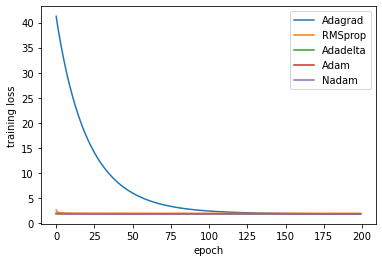

In [11]:
optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam', 'Nadam']
for opt in optimizers:
    x = df[(df['optimizer'] == opt) & (df['regularizer'] == 'l2')]['epoch']
    y = df[(df['optimizer'] == opt) & (df['regularizer'] == 'l2')]['train_loss']
    plt.plot(x,y, label = opt)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend()
plt.show()

# Problem 1.3 With Dropout

In [66]:
rows_d = []
test_result_d = []
epoch = 200

#build model
model = build_dropoutmodel()
print(model.summary())

#compile model 
for opt in optimizers:
    start = time.time()
    model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size = 128,  verbose= 2)
    
    end = time.time()
    
    train_time = end - start 
    
    #record training_loss
    for i in range(epoch):
        rows_d.append([opt, 'dropout', i, history.history['loss'][i]])

    #determine test accuracy and record train_time
    test_loss, test_acc = model.evaluate(x_test, y_test,  batch_size = 128, verbose = 0)
    test_result_d.append([opt, 'dropout', test_loss, test_acc, train_time])


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)              

In [53]:
df_d = pd.DataFrame(rows_d, columns = ['optimizer', 'regularizer', 'epoch', 'train_loss'])
print(df_d)

    optimizer regularizer  epoch  train_loss
0     Adagrad     dropout      0   41.426350
1     Adagrad     dropout      1   39.331089
2     Adagrad     dropout      2   37.506519
3     Adagrad     dropout      3   35.800369
4     Adagrad     dropout      4   34.190258
..        ...         ...    ...         ...
995     Nadam     dropout    195    2.054580
996     Nadam     dropout    196    2.052037
997     Nadam     dropout    197    2.055330
998     Nadam     dropout    198    2.057884
999     Nadam     dropout    199    2.054817

[1000 rows x 4 columns]


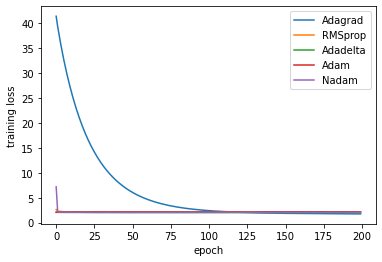

In [70]:
for opt in optimizers:
    x = df_d[(df_d['optimizer'] == opt) & (df_d['regularizer'] == 'dropout')]['epoch']
    y = df_d[(df_d['optimizer'] == opt) & (df_d['regularizer'] == 'dropout')]['train_loss']
    plt.plot(x,y, label = opt)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend()
plt.show()

# Problem 1.4

In [68]:
test_result

[['Adagrad', 'l2', 1.8765023946762085, 0.4683000147342682, 443.3111345767975],
 ['RMSprop', 'l2', 2.0303874015808105, 0.3239000141620636, 530.2822144031525],
 ['Adadelta', 'l2', 1.897221326828003, 0.3752000033855438, 443.3992247581482],
 ['Adam', 'l2', 1.9111177921295166, 0.37279999256134033, 443.3963072299957],
 ['Nadam', 'l2', 1.8919519186019897, 0.3792000114917755, 804.2167756557465]]

In [69]:
test_result_d

[['Adagrad',
  'dropout',
  1.6932499408721924,
  0.48240000009536743,
  444.0087068080902],
 ['RMSprop',
  'dropout',
  2.0786454677581787,
  0.2903999984264374,
  563.633716583252],
 ['Adadelta',
  'dropout',
  1.9616326093673706,
  0.3305000066757202,
  503.4167637825012],
 ['Adam',
  'dropout',
  2.0967202186584473,
  0.2362000048160553,
  443.53918528556824],
 ['Nadam', 'dropout', 2.091763496398926, 0.210999995470047, 783.6976656913757]]

In [76]:
history.history['loss']

[2.1344244480133057,
 2.1309945583343506,
 2.127005100250244,
 2.1285126209259033,
 2.128910541534424,
 2.1249842643737793,
 2.124558687210083,
 2.126284599304199,
 2.1208229064941406,
 2.1214873790740967,
 2.132049798965454,
 2.140632390975952,
 2.1339070796966553,
 2.1244988441467285,
 2.1160244941711426,
 2.120306968688965,
 2.115420341491699,
 2.1146600246429443,
 2.114966630935669,
 2.114903211593628,
 2.117035150527954,
 2.1137819290161133,
 2.1133086681365967,
 2.112745523452759,
 2.1145851612091064,
 2.111621141433716,
 2.112164258956909,
 2.114119529724121,
 2.1126253604888916,
 2.119946241378784,
 2.111860513687134,
 2.1117119789123535,
 2.1108648777008057,
 2.113642692565918,
 2.111586332321167,
 2.11397123336792,
 2.113410711288452,
 2.112149238586426,
 2.1118252277374268,
 2.113434314727783,
 2.11379337310791,
 2.1093740463256836,
 2.1101572513580322,
 2.1133570671081543,
 2.111161947250366,
 2.1129138469696045,
 2.109222412109375,
 2.1145482063293457,
 2.11057710647583,
 

In [77]:
history.history['loss'][-1]

2.1105523109436035

# Problem 2

In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [13]:
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )
num_classes= len(np.unique(y_test))
print('num of classes: %.f' %len(np.unique(y_test)))

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
num of classes: 10


Total dataset size: 70,000 <br />
Training size: 60,000 <br />
Testing size: 10,000 <br />
Number of classes: 10 <br />
Number of images per class:  <br />

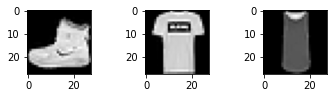

In [14]:
# plot first few images
for i in range(3):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

In [15]:
#pad each image with 0s to turn to 32*32 pixel images
x_train = np.pad(x_train, [(0,0), (0,4),(0,4)], 'constant')
x_test = np.pad(x_test, [(0,0), (0,4),(0,4)], 'constant')
print(x_train.shape)

#reshape to 4-dims so it works with Keras and convert to float to normalize
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1).astype('float32')

print(x_train.shape)
print(x_test.shape)

#divide by 255 to get pixel between 0 and 1
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(60000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [93]:
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )

(60000, 32, 32, 1) (10000, 32, 32, 1) (60000, 10) (10000, 10)


In [16]:
def build_model():
    
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), input_shape=(32,32,1), 
                     activation = 'relu'))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation = 'relu'))
    model.add(AveragePooling2D())

    #flattens output of final pooling layer for the fully connected layer
    model.add(Flatten())
    model.add(Dense(units=120, activation = 'relu'))


    model.add(Dense(units=84, activation = 'relu'))

    #output
    model.add(Dense(units=10, activation = 'softmax'))
    
    return model


In [128]:
MIN_LR = 1e-8
MAX_LR = 1e+2
BATCH_SIZE = 64
NUM_EPOCHS = 5
lr_vals = [1e-8* 10**i for i in range(10)]

In [133]:
lr_vals

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

In [118]:
prob21= []
prob21.append([lr_val, train_loss])

In [134]:
prob2_2 = []
for lr_val in lr_vals:
    print('next learning rate--------')
    model = build_model()
    model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate = lr_val, momentum=0.9),
          metrics=["accuracy"])
    history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs= NUM_EPOCHS, 
                        verbose= 0)
    train_loss = history.history['loss'][-1]
    prob2_2.append([lr_val, train_loss])

next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------


In [138]:
df_2_2 = pd.DataFrame(prob2_2, columns = ['learning_rate', 'training_loss'])
print(df_2_2)

   learning_rate  training_loss
0   1.000000e-08       2.315298
1   1.000000e-07       2.294493
2   1.000000e-06       2.298950
3   1.000000e-05       2.286952
4   1.000000e-04       0.764375
5   1.000000e-03       0.508940
6   1.000000e-02       0.325579
7   1.000000e-01       0.354778
8   1.000000e+00       2.339034
9   1.000000e+01            NaN


In [150]:
import math
x = [math.log(val,10) for val in df_2_2['learning_rate']]

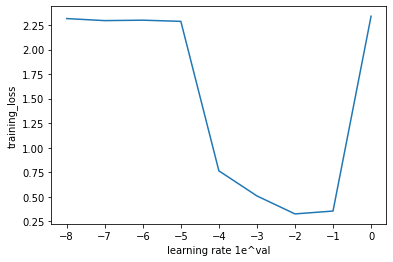

In [154]:
plt.plot(x, df_2_2['training_loss'])
plt.ylabel('training_loss')
plt.xlabel('learning rate 1e^val')
plt.show()

from the curve, we see that


lr_min = 1e-02
lr_max = 1e-05

# Problem 2_3

In [17]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [40]:
MIN_LR = 1e-05
MAX_LR = 1e-02
BATCH_SIZE = 64
STEP_SIZE = 4
EPOCHS = 41

In [33]:
model = build_model()
model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate = MIN_LR, momentum=0.9),
          metrics=["accuracy"])

clr = CyclicLR(mode = 'triangular',
               base_lr=MIN_LR,
               max_lr= MAX_LR,
               step_size= STEP_SIZE * x_train.shape[0] // BATCH_SIZE)
  model.fit(x_train, y_train, epochs = 10, batch_size = 64, 
            callbacks=[callback],validation_split = 0.2, verbose = 0)

In [37]:
clr = CyclicLR(mode = 'exp_range',
               base_lr=MIN_LR,
               max_lr= MAX_LR,
               step_size= STEP_SIZE * x_train.shape[0] // BATCH_SIZE)
earlyStop = EarlyStopping(patience = 20)

In [38]:
H = model.fit(x_train, y_train, batch_size = BATCH_SIZE,
             validation_data = (x_test, y_test), 
              steps_per_epoch = x_train.shape[0] //BATCH_SIZE,
              epochs = EPOCHS, validation_split = 0.2,
              callbacks = [clr, earlyStop],
              verbose = 2)

Epoch 1/50
937/937 - 5s - loss: 0.6339 - accuracy: 0.7646 - val_loss: 0.6074 - val_accuracy: 0.7821
Epoch 2/50
937/937 - 5s - loss: 0.5506 - accuracy: 0.7959 - val_loss: 0.4933 - val_accuracy: 0.8215
Epoch 3/50
937/937 - 5s - loss: 0.4835 - accuracy: 0.8230 - val_loss: 0.4731 - val_accuracy: 0.8267
Epoch 4/50
937/937 - 5s - loss: 0.4314 - accuracy: 0.8411 - val_loss: 0.4494 - val_accuracy: 0.8319
Epoch 5/50
937/937 - 5s - loss: 0.3829 - accuracy: 0.8589 - val_loss: 0.3857 - val_accuracy: 0.8614
Epoch 6/50
937/937 - 5s - loss: 0.3487 - accuracy: 0.8715 - val_loss: 0.3533 - val_accuracy: 0.8694
Epoch 7/50
937/937 - 5s - loss: 0.3171 - accuracy: 0.8836 - val_loss: 0.3354 - val_accuracy: 0.8777
Epoch 8/50
937/937 - 5s - loss: 0.2961 - accuracy: 0.8902 - val_loss: 0.3237 - val_accuracy: 0.8809
Epoch 9/50
937/937 - 5s - loss: 0.2872 - accuracy: 0.8938 - val_loss: 0.3374 - val_accuracy: 0.8753
Epoch 10/50
937/937 - 5s - loss: 0.3007 - accuracy: 0.8881 - val_loss: 0.3331 - val_accuracy: 0.8767

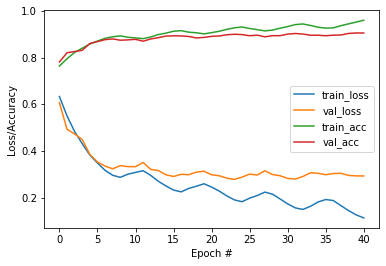

In [42]:
N = np.arange(0, 41)
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

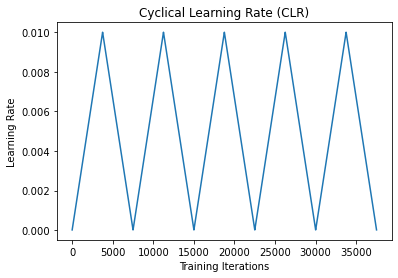

In [43]:
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.show()

In [44]:
#of iteration in one epoch
x_train.shape[0] // BATCH_SIZE

937

In [45]:
#of iteration in one epoch * #of epochs
len(clr.history["lr"])

37500

In [181]:
clr.history["lr"][89951]

7.5268e-05

In [173]:
x_train.shape

(60000, 32, 32, 1)

In [174]:
STEP_SIZE * x_train.shape[0] // BATCH_SIZE

7500

In [177]:
x_train.shape[0] // BATCH_SIZE

937

# Problem 2d 

In [55]:
import math

# 

get the number of iterations using batch size of 64 and epoch of 5 & # of training data

n iter = n_train_size * 5 /batch_size


n_iter = 4685


for given_batch,calculate epoch


4685 = 60,000*epoch/given_batch

get training loss at the end

In [63]:
lr_val = 1e-05

n_iter = (x_train.shape[0] * 5)//64

batch_sizes =  [64, 128, 256, 512, 1024, 2048, 4096, 8192]
calc_epoch = []

for batch in batch_sizes:
    cepoch = math.ceil(n_iter*batch/x_train.shape[0])
    print((batch, cepoch))
    calc_epoch.append(cepoch)

prob2_4 = []

(64, 5)
(128, 10)
(256, 20)
(512, 40)
(1024, 80)
(2048, 160)
(4096, 320)
(8192, 640)


In [ ]:
prob2_4 = []

In [84]:
batch = 256
epoch_at_batch = 20

model = build_model()
model.compile(loss="categorical_crossentropy", 
          optimizer=SGD(learning_rate = lr_val, momentum=0.9),
      metrics=["accuracy"])
start = time.time()
history = model.fit(x_train, y_train, batch_size = batch, epochs = epoch_at_batch,
                    verbose= 0)
end = time.time()
train_time = end-start

train_loss = history.history['loss'][-1]
prob2_4.append([batch, train_loss, train_time])

In [85]:
prob2_4

[[64, 2.2852766513824463, 16.287052154541016],
 [128, 2.262557029724121, 17.115561485290527],
 [8192, 2.2948474884033203, 382.57727432250977],
 [4096, 2.197016954421997, 202.56647777557373],
 [2048, 2.164604902267456, 142.88380908966064],
 [1024, 2.2627971172332764, 82.54933524131775],
 [512, 2.291853666305542, 32.61729979515076],
 [256, 2.2921524047851562, 21.489644050598145]]

In [87]:
df_2_4 = pd.DataFrame(prob2_4, columns = ['batch_size', 'training_loss', 'train_time'])
print(df_2_4)

   batch_size  training_loss  train_time
0          64       2.285277   16.287052
1         128       2.262557   17.115561
2        8192       2.294847  382.577274
3        4096       2.197017  202.566478
4        2048       2.164605  142.883809
5        1024       2.262797   82.549335
6         512       2.291854   32.617300
7         256       2.292152   21.489644


In [89]:
df_2_4= df_2_4.sort_values('batch_size')

[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]


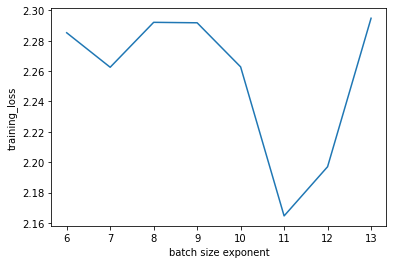

In [99]:
#x= df_2_4['batch_size']
x= [math.log(batch,2) for batch in df_2_4['batch_size']]
print(x)
plt.plot(x, df_2_4['training_loss'])
plt.ylabel('training_loss')
plt.xlabel('batch size exponent')
plt.show()

batch size of 2^11 = 2048 
batch size of 2^9 = 512

# Problem 2.5

bmax = batch size of 2^11 = 2048 <br />
bmin = batch size of 2^9 = 512 <br />

Algorithm for batch size finding (which should exponentially increase) <br />

1. Set small and large batch size bounds
2. Start training network
3. Decrease batch size exponentially after each batch update
4. Record loss and batch size at end of each batch
5. Train for 3-5 epochs
6. Plot loss and batch size 
7. Examine plot and identify optimal Batch Size
8. Update batch size
9. Train network on full set of data

Modified to reflect how we found bmin and bmax
1. Set small and large batch size bounds, Set number of iterations
2. Train network with batch size and epoch that lead to same number of iterations
4. Record loss and batch size at end 
6. Plot loss and batch size 
7. Examine plot and identify optimal Batch Size min and batch size max
8. Update batch size
9. Train network on full set of data


# Problem 2.6

Learning rate decrease is equivalent to batch size increase. So the analogous trajectory for exponential decay of learning rate would be to exponentially increase the batch size. 

## cyclical batch size policy- exponential increase

# Problem 4

Explain cutout regularization and its advantages compared to simple dropout (as argued in the paper by DeVries et al) in your own words. Select any 2 images from CIFAR10 and show how does these images look after applying cutout. Use a square-shaped fixed size zero-mask to a random location of each image and generate its cutout version. Refer to the paper by DeVries et al (Section 3) and associated github repository. <br />

Cutout regularization is when we randomly select square regions in the input data to mask out during training. Like dropout, it's a regularization method to reduce over-fitting. 

According to DeVries et al, one of the big advantage of cutout over dropout is in convolutional layer. In dropout for Conv, we are dropping certain pixels, but neighboring pixels still have similar information, so dropout end-up being not as effective in Conv layers as compared to FC layer. With cutout, we remove group of pixels at the input level, so this might be removing whole objects from the input and all the layers that come after it, forcing the model to consider the full image rather than small key parts of image. 

In [ ]:
import torch
import numpy as np


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [111]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [112]:
x_train = x_train /255.0
x_test = x_test /255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

In [113]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [114]:
def cutout(img, length, n_holes):
    h,w,channels = img.shape
    
    new_img = img
    
    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)
        
        new_img[y1: y2, x1: x2] = 0
        return new_img

Original images:


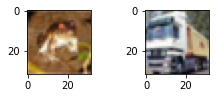

Images with cutout:


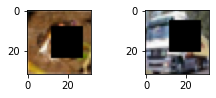

In [115]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(cutout(x_train[i], 16, 1))
plt.show()

RandomFlip- https://www.tensorflow.org/tutorials/images/data_augmentation

x_test[0].shape
print(x_test[0].shape)
A = x_test[0]
print(A[0][0])
#((top, bottom), (left, right))
Y = np.pad(A, [(4,4), (4,4), (0,0)], 'constant')
print(Y[4][4])

In [170]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [171]:
#pad each image with 0s to turn  32*32 pixel images to 40x40 with 4 pixels on each side
x_train = np.pad(x_train, [(0,0), (4,4), (4,4), (0,0)], 'constant')
x_test = np.pad(x_test, [(0,0), (4,4), (4,4), (0,0)], 'constant')
print(x_train.shape)

#convert to float to normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train /255.0
x_test = x_test /255.0

(50000, 40, 40, 3)
50000 train samples
10000 test samples


In [172]:
x_train[0].shape

(40, 40, 3)

In [173]:
x_train[0][4]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746],
       [0.26666668, 0.21176471, 0.16470589],
       [0.38431373, 0.28627452, 0.20392157],
       [0.46666667, 0.35686275, 0.24705882],
       [0.54509807, 0.41960785, 0.29411766],
       [0.5686275 , 0.43137255, 0.3137255 ],
       [0.58431375, 0.45882353, 0.34901962],
       [0.58431375, 0.47058824, 0.3647059 ],
       [0.5137255 , 0.40392157, 0.3019608 ],
       [0.49019608, 0.3882353 , 0.29803923],
       [0.5568628 , 0.4509804 , 0.35686275],
       [0.5647059 , 0.4392157 , 0.3372549 ],
       [0.5372549 , 0.4117647 , 0.30980393],
       [0.5058824 , 0.38039216, 0.2784314 ],
       [0.5372549 , 0.41568628, 0.30980393],
       [0.5254902 , 0.41568628, 0.29803923],
       [0.

In [185]:
#Randomly crop
cropp = tf.image.random_crop(x_train[0], size=[32, 32, 3])
cropp2 = tf.image.random_crop(x_train[0], size=[32, 32, 3])

In [180]:
x_train[0].shape

(40, 40, 3)

In [181]:
cropp.shape

TensorShape([32, 32, 3])

Cropped images:


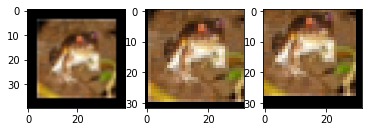

In [192]:
print("Cropped images:")

plt.subplot(130 + 1 + 0)
plt.imshow(x_train[0])
plt.subplot(130 + 1 + 1)
plt.imshow(cropp)
plt.subplot(130 + 1 + 2)
plt.imshow(cropp2)
plt.show()

# flip image

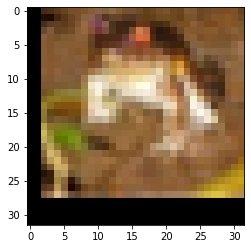

In [194]:
flipped = tf.image.flip_left_right(cropp2)
plt.imshow(flipped)

for each image, A random32×32part of the paddedimage is then cropped and with a 0.5 probability flipped horizontally. <br />
sample of flips, sample of crops. <br />
choose one <br />
total size = 2M <br />
4 pixels are padded on each side, a 32×32 crop is randomly sampled from the padded image or its horizontal flip. 
For testing, we only evaluate the single view of the original 32×32 image.

# Using ImageDataGenerator to automatically crop and flip

In [ ]:
history_no_aug = m_no_aug.fit(
    x_train, y_train,
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, y_test))

loss_no_aug, acc_no_aug = m_no_aug.evaluate(x_test,  y_test)

In [ ]:
width_shift = 4/32
height_shift = 4/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(x_train)

iterator_train = datagen.flow(x_train, y_train, batch_size = 64, 
                              shuffle=False)
steps = int(x_train.shape[0]/64)
model.fit_generator(iterator_train, steps_per_epoch = steps, epochs = 3)
batch_images, batch_labels = next(it)

# question 4.3 using provided code

In [ ]:
python main.py --dataset cifar10 --model resnet --model-config "{'depth': 44}"  --duplicates 2 --cutout -b 64 --epochs 100 --save resnet44_cutout_m-40